# 模型构建代码解析

## 1.函数解析

* x.get_shape()，只有tensor才可以使用这种方法，返回的是一个元组，需要通过as_list()的操作转换成list.
* //：取整除 - 返回商的整数部分（向下取整）；如：9//2=4。
* tf.slice(inputs, begin, size, name)；作用：从列表、数组、张量等对象中抽取一部分数据；begin[]或size[]中出现-1,表示抽取对应维度上的所有元素。
* tf.concat()：拼接张量的函数；在axis=？轴上拼接。
* __init__：定义类的时候，若是添加__init__方法，那么在创建类的实例的时候，实例会自动调用这个方法，一般用来对实例的属性进行初使化。第一个参数必须是self。
* tf.get_variable(name,  shape, initializer): name就是变量的名称，shape是变量的维度，initializer是变量初始化的方式，初始化的方式有以下几种：<br>
  tf.constant_initializer：常量初始化函数<br>
  tf.random_normal_initializer：正态分布<br>
  tf.truncated_normal_initializer：截取的正态分布<br>
  tf.random_uniform_initializer：均匀分布<br>
  tf.zeros_initializer：全部是0<br>
  tf.ones_initializer：全是1<br>
  tf.uniform_unit_scaling_initializer：满足均匀分布，但不影响输出数量级的随机值<br>
* tf.placeholder:占位符其实就是一个变量，该变量比较特殊，一般都在最后运行时才给它赋值。它允许我们创建操作并构建计算图，而不需要数据。在tensorflow中我们会通过这些占位符(placeholder)去把数据输入到之前构建的计算图中。
* tf.compat.v1.variable_scope：用于定义创建变量（层）的操作的上下文管理器，此上下文管理器验证（可选）values是否来自同一图形，确保图形是默认的图形，并推送名称范围和变量范围。<br>
  tf.compat.v1.add_to_collection：将tensor对象放入同一个集合，其中tf.compat.v1.GraphKeys.WEIGHTS是获取所有的权重矩阵；<br> tf.contrib.layers.l2_regularizer(1.)(conv_w)是将conv_w进行l2正则化，可以防止过拟合问题；<br>
  tf.nn.bias_add则是卷积结果与偏置参数相加。<br>
链接：https://www.jianshu.com/p/d490bdf97c47
* tf.nn.dropout(x,keep_prob,noise_shape=None,seed=None,name=None)是tensorflow里面为了防止或减轻过拟合而使用的函数，它一般用在全连接层。<br>
  x：指输入，输入tensor<br>
  keep_prob: float类型，每个元素被保留下来的概率，设置神经元被选中的概率,在初始化时keep_prob是一个占位符, keep_prob = tf.placeholder(tf.float32) 。tensorflow在run时设置keep_prob具体的值，例如keep_prob: 0.5<br>
  noise_shape  : 一个1维的int32张量，代表了随机产生“保留/丢弃”标志的shape。<br>
  seed : 整形变量，随机数种子。<br>
  name：指定该操作的名字。<br>

## 2.正则化（Regularization）
* 损失函数后面会添加一个额外项，常用的额外项一般有两种，一般英文称作 ℓ 1 \ell_1 ℓ1​-norm 和 ℓ 2 \ell_2 ℓ2​-norm，中文称作 L1正则化 和 L2正则化，或者 L1范数 和 L2范数。
 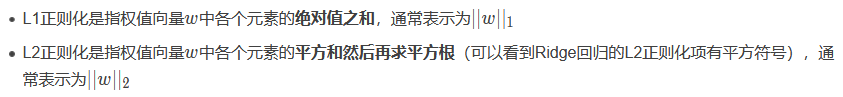
 一般都会在正则化项之前添加一个系数，Python的机器学习包sklearn中用 α \alpha α表示，一些文章也用 λ \lambda λ表示。这个系数需要用户指定。<br>
 作用：
 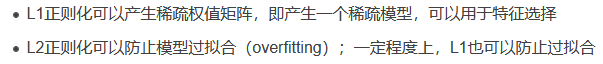
 链接：https://blog.csdn.net/jinping_shi/article/details/52433975

## 3.批归一化（Batch Normalization）
链接：https://blog.csdn.net/vict_wang/article/details/88075861
* Batch Normalization（简称BN）就是对每一批数据进行归一化。BN可以作为神经网络的一层，放在激活函数（如Relu）之前。BN的算法流程如下图：
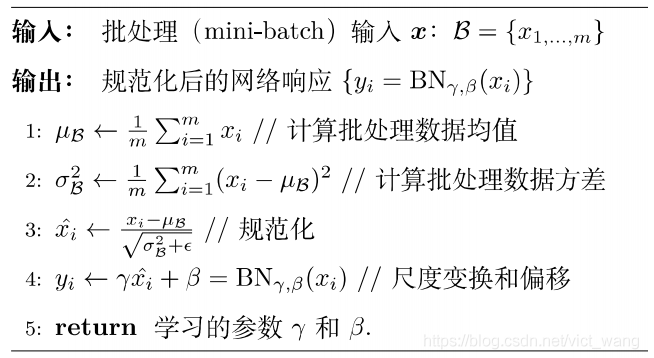
BN在深层神经网络的作用非常明显：若神经网络训练时遇到收敛速度较慢，或者“梯度爆炸”等无法训练的情况发生时都可以尝试用BN来解决。同时，常规使用情况下同样可以加入BN来加速模型训练，甚至提升模型精度。

In [ ]:
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()   #是2.0的版本，默认是命令式编程，需要手动进行取消
import numpy as np
import logging

#连接的下采样池化层和后面的上采样反卷积层
def crop_and_concat(net1, net2):
  """
  the size(net1) <= size(net2)
  """
  net1_shape = net1.get_shape().as_list()    
  net2_shape = net2.get_shape().as_list()
  # print(net1_shape)
  # print(net2_shape)
  # if net2_shape[1] >= net1_shape[1] and net2_shape[2] >= net1_shape[2]:
  offsets = [0, (net2_shape[1] - net1_shape[1]) // 2, (net2_shape[2] - net1_shape[2]) // 2, 0] 
  size = [-1, net1_shape[1], net1_shape[2], -1]  
  net2_resize = tf.slice(net2, offsets, size)  
  return tf.concat([net1, net2_resize], 3)   
  # else:
  #     offsets = [0, (net1_shape[1] - net2_shape[1]) // 2, (net1_shape[2] - net2_shape[2]) // 2, 0]
  #     size = [-1, net2_shape[1], net2_shape[2], -1]
  #     net1_resize = tf.slice(net1, offsets, size)
  #     return tf.concat([net1_resize, net2], 3)

def crop_only(net1, net2):
  """
  the size(net1) <= size(net2)
  """
  net1_shape = net1.get_shape().as_list()
  net2_shape = net2.get_shape().as_list()
  # print(net1_shape)
  # print(net2_shape)
  # if net2_shape[1] >= net1_shape[1] and net2_shape[2] >= net1_shape[2]:
  offsets = [0, (net2_shape[1] - net1_shape[1]) // 2, (net2_shape[2] - net1_shape[2]) // 2, 0]
  size = [-1, net1_shape[1], net1_shape[2], -1]
  net2_resize = tf.slice(net2, offsets, size)
  #return tf.concat([net1, net2_resize], 3)
  return net2_resize

class Model:
  def __init__(self, config, input_batch=None, mode='train'):      #定义构造函数
    self.depths = config.depths
    self.filters_root = config.filters_root
    self.kernel_size = config.kernel_size
    self.dilation_rate = config.dilation_rate
    self.pool_size = config.pool_size
    self.X_shape = config.X_shape
    self.Y_shape = config.Y_shape
    self.n_channel = config.n_channel
    self.n_class = config.n_class
    self.class_weights = config.class_weights
    self.batch_size = config.batch_size
    self.loss_type = config.loss_type
    self.weight_decay = config.weight_decay
    self.optimizer = config.optimizer
    self.learning_rate = config.learning_rate
    self.decay_step = config.decay_step
    self.decay_rate = config.decay_rate
    self.momentum = config.momentum
    self.global_step = tf.compat.v1.get_variable(name="global_step", initializer=0, dtype=tf.int32)
    self.summary_train = []
    self.summary_valid = []

    self.build(input_batch, mode=mode)

  def add_placeholders(self, input_batch=None, mode="train"):
    if input_batch is None:
      self.X = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, self.X_shape[0], self.X_shape[1], self.X_shape[2]], name='X')
      self.Y = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, self.Y_shape[0], self.Y_shape[1], self.n_class], name='y')
    else:
      self.X = input_batch[0]
      if mode in ["train", "valid", "test"]:
        self.Y = input_batch[1]
      self.input_batch = input_batch

    self.is_training = tf.compat.v1.placeholder(dtype=tf.bool, name="is_training")
    # self.keep_prob = tf.placeholder(dtype=tf.float32, name="keep_prob")
    self.drop_rate = tf.compat.v1.placeholder(dtype=tf.float32, name="drop_rate")


  def add_prediction_op(self):
    logging.info("Model: depths {depths}, filters {filters}, "
           "filter size {kernel_size[0]}x{kernel_size[1]}, "
           "pool size: {pool_size[0]}x{pool_size[1]}, "
           "dilation rate: {dilation_rate[0]}x{dilation_rate[1]}".format(
            depths=self.depths,
            filters=self.filters_root,
            kernel_size=self.kernel_size,
            dilation_rate=self.dilation_rate,
            pool_size=self.pool_size))

    if self.weight_decay > 0:
      weight_decay = tf.constant(self.weight_decay, dtype=tf.float32, name="weight_constant")   #权重衰减
      self.regularizer = tf.keras.regularizers.l2(l=0.5 * (weight_decay))   #正则化L2；正则化惩罚项，用来惩罚神经元的加权矩阵，防止过拟合
    else:
      self.regularizer = None
 
    self.initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")

    # down sample layers
    convs = [None] * self.depths # store output of each depth

    with tf.compat.v1.variable_scope("Input"):
      net = self.X
      net = tf.compat.v1.layers.conv2d(net,
                   filters=self.filters_root,
                   kernel_size=self.kernel_size,
                   activation=None,
                   padding='same',
                   dilation_rate=self.dilation_rate,
                   kernel_initializer=self.initializer,
                   kernel_regularizer=self.regularizer,
                   #bias_regularizer=self.regularizer,
                   name="input_conv")
      net = tf.compat.v1.layers.batch_normalization(net,
                        training=self.is_training,
                        name="input_bn")
      net = tf.nn.relu(net,
               name="input_relu")
      # net = tf.nn.dropout(net, self.keep_prob)
      net = tf.compat.v1.layers.dropout(net,
                  rate=self.drop_rate,
                  training=self.is_training,
                  name="input_dropout")


    for depth in range(0, self.depths):
      with tf.compat.v1.variable_scope("DownConv_%d" % depth):
        filters = int(2**(depth) * self.filters_root)

        net = tf.compat.v1.layers.conv2d(net,
                     filters=filters,
                     kernel_size=self.kernel_size,
                     activation=None,
                     use_bias=False,
                     padding='same',
                     dilation_rate=self.dilation_rate,
                     kernel_initializer=self.initializer,
                     kernel_regularizer=self.regularizer,
                     #bias_regularizer=self.regularizer,
                     name="down_conv1_{}".format(depth + 1))
        net = tf.compat.v1.layers.batch_normalization(net,
                          training=self.is_training,
                          name="down_bn1_{}".format(depth + 1))
        net = tf.nn.relu(net,
                 name="down_relu1_{}".format(depth+1))
        net = tf.compat.v1.layers.dropout(net,
                    rate=self.drop_rate,
                    training=self.is_training,
                    name="down_dropout1_{}".format(depth + 1))

        convs[depth] = net

        if depth < self.depths - 1:
          net = tf.compat.v1.layers.conv2d(net,
                       filters=filters,
                       kernel_size=self.kernel_size,
                       strides=self.pool_size,
                       activation=None,
                       use_bias=False,
                       padding='same',
                       dilation_rate=self.dilation_rate,
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       #bias_regularizer=self.regularizer,
                       name="down_conv3_{}".format(depth + 1))
          net = tf.compat.v1.layers.batch_normalization(net,
                            training=self.is_training,
                            name="down_bn3_{}".format(depth + 1))
          net = tf.nn.relu(net,
                   name="down_relu3_{}".format(depth+1))
          net = tf.compat.v1.layers.dropout(net,
                    rate=self.drop_rate,
                    training=self.is_training,
                    name="down_dropout3_{}".format(depth + 1))


    # up layers
    for depth in range(self.depths - 2, -1, -1):
      with tf.compat.v1.variable_scope("UpConv_%d" % depth):
        filters = int(2**(depth) * self.filters_root)
        net = tf.compat.v1.layers.conv2d_transpose(net,
                         filters=filters,
                         kernel_size=self.kernel_size,
                         strides=self.pool_size,
                         activation=None,
                         use_bias=False,
                         padding="same",
                         kernel_initializer=self.initializer,
                         kernel_regularizer=self.regularizer,
                         #bias_regularizer=self.regularizer,
                         name="up_conv0_{}".format(depth+1))
        net = tf.compat.v1.layers.batch_normalization(net,
                          training=self.is_training,
                          name="up_bn0_{}".format(depth + 1))
        net = tf.nn.relu(net,
                 name="up_relu0_{}".format(depth+1))
        net = tf.compat.v1.layers.dropout(net,
                    rate=self.drop_rate,
                    training=self.is_training,
                    name="up_dropout0_{}".format(depth + 1))

        
        #skip connection
        net = crop_and_concat(convs[depth], net)
        #net = crop_only(convs[depth], net)

        net = tf.compat.v1.layers.conv2d(net,
                     filters=filters,
                     kernel_size=self.kernel_size,
                     activation=None,
                     use_bias=False,
                     padding='same',
                     dilation_rate=self.dilation_rate,
                     kernel_initializer=self.initializer,
                     kernel_regularizer=self.regularizer,
                     #bias_regularizer=self.regularizer,
                     name="up_conv1_{}".format(depth + 1))
        net = tf.compat.v1.layers.batch_normalization(net,
                          training=self.is_training,
                          name="up_bn1_{}".format(depth + 1))
        net = tf.nn.relu(net,
                 name="up_relu1_{}".format(depth + 1))
        net = tf.compat.v1.layers.dropout(net,
                    rate=self.drop_rate,
                    training=self.is_training,
                    name="up_dropout1_{}".format(depth + 1))


    # Output Map
    with tf.compat.v1.variable_scope("Output"):
      net = tf.compat.v1.layers.conv2d(net,
                   filters=self.n_class,
                   kernel_size=(1,1),
                   activation=None,
                   padding='same',
                   #dilation_rate=self.dilation_rate,
                   kernel_initializer=self.initializer,
                   kernel_regularizer=self.regularizer,
                   #bias_regularizer=self.regularizer,
                   name="output_conv")
      # net = tf.nn.relu(net,
      #                     name="output_relu")
      # net = tf.layers.dropout(net,
      #                         rate=self.drop_rate,
      #                         training=self.is_training,
      #                         name="output_dropout")
      # net = tf.layers.batch_normalization(net,
      #                                    training=self.is_training,
      #                                    name="output_bn")
      output = net
     
    with tf.compat.v1.variable_scope("representation"):
      self.representation = convs[-1]

    with tf.compat.v1.variable_scope("logits"):
      self.logits = output
      tmp = tf.compat.v1.summary.histogram("logits", self.logits)
      self.summary_train.append(tmp)

    with tf.compat.v1.variable_scope("preds"):
      self.preds = tf.nn.softmax(output)
      tmp = tf.compat.v1.summary.histogram("preds", self.preds)
      self.summary_train.append(tmp)
